<a href="https://colab.research.google.com/github/MeenaRuwandi/INCS_870_Project_IDSforMinorAttacks/blob/meena/Exp2_generalSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn
!pip install scikit-learn
!pip install seaborn
!pip install gdown
!pip install xgboost
import gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 4.9 MB/s eta 0:00:00


In [2]:
# Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [3]:
file_ids = [
    '1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde',  # Wednesday dataset
    '1WL00LFkCA2ylV8_8c6jm52bnEhGLcKsq']  # Thursday Morining dataset

# Download each file
for i, file_id in enumerate(file_ids):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, f'dataset_{i + 1}.csv', quiet=False)  # Saves as dataset_1.csv, dataset_2.csv, etc.

Downloading...
From (original): https://drive.google.com/uc?id=1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde
From (redirected): https://drive.google.com/uc?id=1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde&confirm=t&uuid=df7abadf-b6e1-4a21-bfc1-c6f458fa2d07
To: /content/dataset_1.csv
100%|██████████| 225M/225M [00:02<00:00, 93.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WL00LFkCA2ylV8_8c6jm52bnEhGLcKsq
To: /content/dataset_2.csv
100%|██████████| 52.0M/52.0M [00:00<00:00, 80.6MB/s]


In [4]:
dataset_paths = [
    '/content/dataset_1.csv','/content/dataset_2.csv']

# Make the data frame
dataframes = [pd.read_csv(path) for path in dataset_paths]

# Combine all datasets into one dataframe
combined_dataset = pd.concat(dataframes, ignore_index=True)

combined_dataset.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,863069.000000,8.630690e+05,863069.000000,863069.000000,8.630690e+05,8.630690e+05,863069.000000,863069.000000,863069.000000,863069.000000,...,863069.000000,863069.000000,8.630690e+05,8.630690e+05,8.630690e+05,8.630690e+05,8.630690e+05,8.630690e+05,8.630690e+05,8.630690e+05
mean,6123.157330,2.493452e+07,10.655431,11.755382,5.554667e+02,1.992481e+04,220.601763,16.537313,58.123094,75.856690,...,7.266929,26.528879,8.871007e+04,4.744110e+04,1.631125e+05,6.058081e+04,1.847505e+07,4.066081e+05,1.882314e+07,1.814301e+07
std,16276.972347,4.132275e+07,834.919392,1103.785281,6.498214e+03,2.528963e+06,579.010897,48.861499,147.477310,212.643439,...,799.900462,6.345935,6.852438e+05,4.553637e+05,1.075841e+06,5.966177e+05,3.540628e+07,4.096570e+06,3.576154e+07,3.533630e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,1.980000e+02,2.000000,1.000000,1.200000e+01,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,5.277200e+04,2.000000,2.000000,7.600000e+01,1.720000e+02,45.000000,0.000000,40.000000,0.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,5.570988e+07,7.000000,6.000000,3.610000e+02,4.707000e+03,330.000000,35.000000,55.000000,122.398257,...,2.000000,32.000000,8.980000e+02,0.000000e+00,8.990000e+02,7.610000e+02,9.986750e+06,0.000000e+00,1.000000e+07,9.761932e+06
max,65529.000000,1.200000e+08,203943.000000,272353.000000,1.224076e+06,6.270000e+08,24820.000000,2065.000000,4640.757576,6429.190773,...,197124.000000,60.000000,1.030000e+08,7.420000e+07,1.050000e+08,1.030000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [5]:
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863069 entries, 0 to 863068
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             863069 non-null  int64  
 1    Flow Duration                863069 non-null  int64  
 2    Total Fwd Packets            863069 non-null  int64  
 3    Total Backward Packets       863069 non-null  int64  
 4   Total Length of Fwd Packets   863069 non-null  int64  
 5    Total Length of Bwd Packets  863069 non-null  int64  
 6    Fwd Packet Length Max        863069 non-null  int64  
 7    Fwd Packet Length Min        863069 non-null  int64  
 8    Fwd Packet Length Mean       863069 non-null  float64
 9    Fwd Packet Length Std        863069 non-null  float64
 10  Bwd Packet Length Max         863069 non-null  int64  
 11   Bwd Packet Length Min        863069 non-null  int64  
 12   Bwd Packet Length Mean       863069 non-nul

In [6]:
# Pre processing
x = combined_dataset.drop(columns=[' Label'])
y = combined_dataset[' Label']
# Handle missing values
x.fillna(x.mean(), inplace=True)

# Get 'Label' column that indicates attack types
class_distribution = combined_dataset[' Label'].value_counts()
print(class_distribution)

class_distribution = y.value_counts()
class_distribution_percent = y.value_counts(normalize=True) * 100

print("\nClass Distribution (Percentages):\n", class_distribution_percent)

 Label
BENIGN                        608217
DoS Hulk                      231073
DoS GoldenEye                  10293
DoS slowloris                   5796
DoS Slowhttptest                5499
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

Class Distribution (Percentages):
  Label
BENIGN                        70.471422
DoS Hulk                      26.773410
DoS GoldenEye                  1.192605
DoS slowloris                  0.671557
DoS Slowhttptest               0.637145
Web Attack � Brute Force       0.174609
Web Attack � XSS               0.075544
Web Attack � Sql Injection     0.002433
Heartbleed                     0.001275
Name: proportion, dtype: float64


<ipython-input-7-31f827e114e3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='plasma')


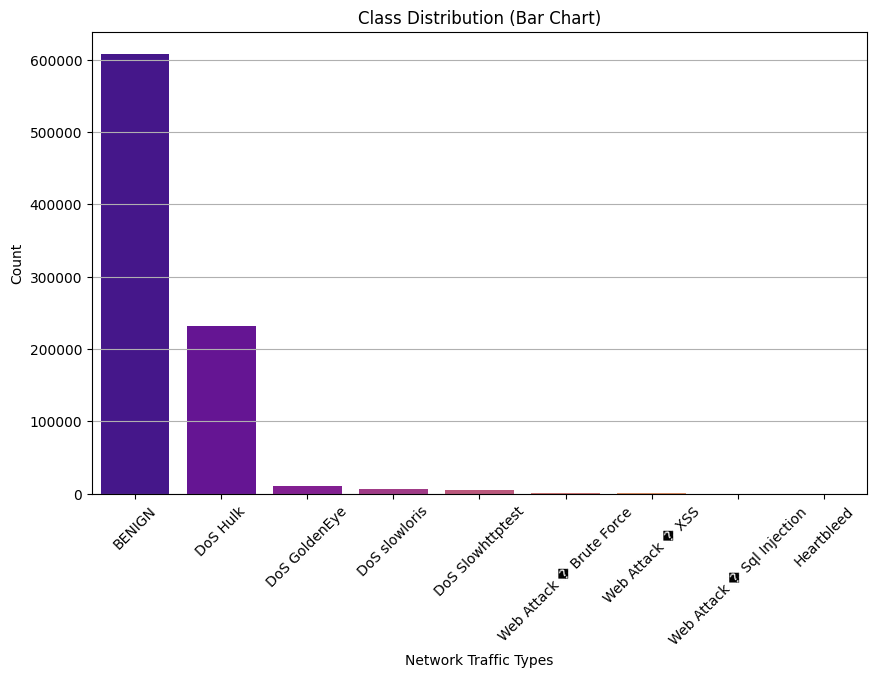

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for class distribution feature types
class_counts = y.value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='plasma')
plt.title('Class Distribution (Bar Chart)')
plt.xlabel('Network Traffic Types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [8]:
# Get an overview of the dataset
print(combined_dataset.shape)
print(combined_dataset.head())
print(combined_dataset.info())  # Review structure, data types, and non-null counts
print(combined_dataset.describe())  # Summary statistics

(863069, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0                 80           38308                   1   
1                389             479                  11   
2                 88            1095                  10   
3                389           15206                  17   
4                 88            1092                   9   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        1                            6   
1                        5                          172   
2                        6                         3150   
3                       12                         3452   
4                        6                         3150   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             6                       6   
1                           326                      79   
2                          3150                    1575   
3                          6660    

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


        Destination Port   Flow Duration   Total Fwd Packets  \
count      863069.000000    8.630690e+05       863069.000000   
mean         6123.157330    2.493452e+07           10.655431   
std         16276.972347    4.132275e+07          834.919392   
min             0.000000   -1.000000e+00            1.000000   
25%            53.000000    1.980000e+02            2.000000   
50%            80.000000    5.277200e+04            2.000000   
75%           443.000000    5.570988e+07            7.000000   
max         65529.000000    1.200000e+08       203943.000000   

        Total Backward Packets  Total Length of Fwd Packets  \
count            863069.000000                 8.630690e+05   
mean                 11.755382                 5.554667e+02   
std                1103.785281                 6.498214e+03   
min                   0.000000                 0.000000e+00   
25%                   1.000000                 1.200000e+01   
50%                   2.000000               

In [9]:
#Handle the missing values, NaN values and clean the dataset
#check for missing values
missing_values=combined_dataset.isnull().sum()
print("missing values in each column :\n", missing_values[missing_values>0])

# Calculate total missing values
total_missing_values = missing_values.sum()
print("\nTotal missing values in the dataset:", total_missing_values)

#fill missing values with the mean value of 'Flow Bytes/s' column with its mean value
meanVal = combined_dataset['Flow Bytes/s'].mean()

#verify if all the missing values are handled
combined_dataset['Flow Bytes/s'].fillna(meanVal, inplace=True)
missingValCheck = combined_dataset.isnull().sum()

# Check for total missing values after dropping rows
missing_values_after_dropping = combined_dataset.isna().sum().sum()
print("Total missing values after dropping rows:", missing_values_after_dropping)

# Show how many rows are left after dropping rows with missing values
remaining_rows = combined_dataset.shape[0]
print("Total rows remaining after dropping rows with missing values:", remaining_rows)  # Before Handling missing values number of raws = 863069

# Check how many duplicate records are in the dataset before removing them
duplicate_records = combined_dataset.duplicated().sum()
print("Total duplicate records in the dataset:", duplicate_records)

# Remove duplicate records
combined_dataset = combined_dataset.drop_duplicates()

# Checking if duplicates were removed
print("Data shape after removing duplicates:", combined_dataset.shape)

missing values in each column :
 Flow Bytes/s    1028
dtype: int64

Total missing values in the dataset: 1028
Total missing values after dropping rows: 0
Total rows remaining after dropping rows with missing values: 863069


<ipython-input-9-e5d79340f787>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_dataset['Flow Bytes/s'].fillna(meanVal, inplace=True)


Total duplicate records in the dataset: 94003
Data shape after removing duplicates: (769066, 79)


In [10]:
combined_dataset.info()
# Class distribution after cleaning the missing values & duplicate racords
print(combined_dataset[' Label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 769066 entries, 0 to 863068
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             769066 non-null  int64  
 1    Flow Duration                769066 non-null  int64  
 2    Total Fwd Packets            769066 non-null  int64  
 3    Total Backward Packets       769066 non-null  int64  
 4   Total Length of Fwd Packets   769066 non-null  int64  
 5    Total Length of Bwd Packets  769066 non-null  int64  
 6    Fwd Packet Length Max        769066 non-null  int64  
 7    Fwd Packet Length Min        769066 non-null  int64  
 8    Fwd Packet Length Mean       769066 non-null  float64
 9    Fwd Packet Length Std        769066 non-null  float64
 10  Bwd Packet Length Max         769066 non-null  int64  
 11   Bwd Packet Length Min        769066 non-null  int64  
 12   Bwd Packet Length Mean       769066 non-null  fl

In [11]:
import numpy as np
import pandas as pd

# Assuming combined_dataset is already defined and contains your data

# Automatically detect numerical columns
numerical_cols = combined_dataset.select_dtypes(include=['float64', 'int64']).columns

# Check for NaN values before processing
print("NaN values in dataset before processing:\n", combined_dataset[numerical_cols].isna().sum())
nan_count_before = combined_dataset[numerical_cols].isna().sum().sum()
print("Total NaN values in dataset before processing:", nan_count_before)

# Check for infinity values
print("Infinity values in dataset (by column):\n", np.isinf(combined_dataset[numerical_cols]).sum())
infinity_count = np.isinf(combined_dataset[numerical_cols]).sum().sum()
print("Total Infinity values in dataset:", infinity_count)

# Fill NaN with the mean of each column
combined_dataset[numerical_cols] = combined_dataset[numerical_cols].fillna(combined_dataset[numerical_cols].mean())

# Check NaN values after filling with mean
nan_count_after_filling_mean = combined_dataset[numerical_cols].isna().sum().sum()
print("Total NaN values in dataset after filling with mean:", nan_count_after_filling_mean)

# Replace infinity with NaN
combined_dataset[numerical_cols] = combined_dataset[numerical_cols].replace([np.inf, -np.inf], np.nan)

# Check NaN values after replacing infinity
nan_count_after_replacing_infinity = combined_dataset[numerical_cols].isna().sum().sum()
print("Total NaN values in dataset after replacing infinity:", nan_count_after_replacing_infinity)

# Fill NaN with the mean of each column again
combined_dataset[numerical_cols] = combined_dataset[numerical_cols].fillna(combined_dataset[numerical_cols].mean())

# Final check for NaN values
final_nan_count = combined_dataset[numerical_cols].isna().sum().sum()
print("Total NaN values in dataset after all processing:", final_nan_count)

# Check for infinity values again after processing
infinity_count_after_processing = np.isinf(combined_dataset[numerical_cols]).sum().sum()
print("Total Infinity values in dataset after processing:", infinity_count_after_processing)

NaN values in dataset before processing:
  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Active Min                    0
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
Length: 78, dtype: int64
Total NaN values in dataset before processing: 0
Infinity values in dataset (by column):
  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Active Min                    0
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
Length: 78, dtype: int64
Total Infinity values in dataset: 832
Total NaN values in dataset after filling with mean: 0

Shape of features (X): (769066, 78)
Shape of target (y): (769066,)
First 5 rows of features (X):
     Destination Port   Flow Duration   Total Fwd Packets  \
0                 80           38308                   1   
1                389             479                  11   
2                 88            1095                  10   
3                389           15206                  17   
4                 88            1092                   9   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        1                            6   
1                        5                          172   
2                        6                         3150   
3                       12                         3452   
4                        6                         3150   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             6                       6   
1                           326                      79   
2        

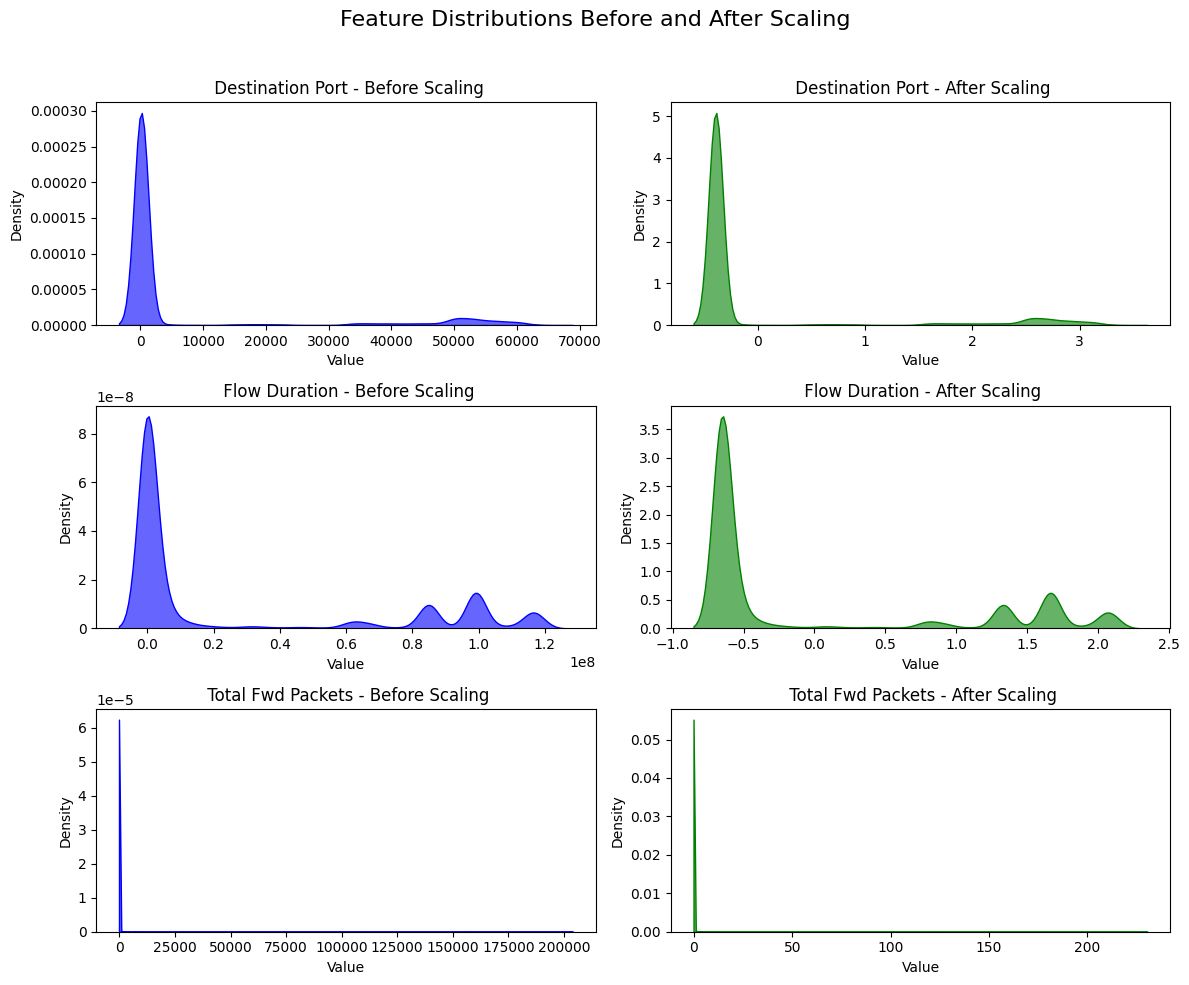

First 5 rows of scaled features (selected):
    Destination Port  Flow Duration  Total Fwd Packets
0         -0.396223      -0.652799          -0.012096
1         -0.378146      -0.653683          -0.000790
2         -0.395755      -0.653669          -0.001920
3         -0.378146      -0.653339           0.005994
4         -0.395755      -0.653669          -0.003051


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Ensure that X (features) and y (target) are prepared from previous steps
X = combined_dataset.drop(' Label', axis=1)  # Assuming 'Label' is the target column
y = combined_dataset[' Label']  # Target variable

# Display the shapes of X and y
print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)

# Display the first few rows of features and target
print("First 5 rows of features (X):\n", X.head())
print("First 5 rows of target (y):\n", y.head())

# Encode the labels (target variable) using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the entire features dataset

# Create a DataFrame from the scaled data for easier manipulation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Step 1: Display the actual column names in the dataset
print("Available columns in the dataset:\n", X.columns)

# Step 2: Select actual columns from the dataset
# Let's say you want to visualize the first three features from your dataset
features_to_visualize = X.columns[:3]  # Selecting the first three features dynamically

# Step 3: Select the chosen features from the scaled dataset
X_selected_scaled = X_scaled_df[features_to_visualize]

# Display the first 5 rows of selected features (already scaled)
print("\nFirst 5 rows of selected features (already scaled):\n", X_selected_scaled.head())

# Plot comparison of feature distribution before and after scaling
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle('Feature Distributions Before and After Scaling', fontsize=16)

# Loop through each feature to plot before and after scaling
for idx, feature in enumerate(features_to_visualize):

    # Before Scaling plot (left column)
    sns.kdeplot(X[feature], label=f'{feature} (Before Scaling)', fill=True, color='blue', ax=axes[idx, 0], alpha=0.6)
    axes[idx, 0].set_title(f'{feature} - Before Scaling', fontsize=12)
    axes[idx, 0].set_xlabel('Value')
    axes[idx, 0].set_ylabel('Density')

    # After Scaling plot (right column)
    sns.kdeplot(X_selected_scaled[feature], label=f'{feature} (After Scaling)', fill=True, color='green', ax=axes[idx, 1], alpha=0.6)
    axes[idx, 1].set_title(f'{feature} - After Scaling', fontsize=12)
    axes[idx, 1].set_xlabel('Value')
    axes[idx, 1].set_ylabel('Density')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Verify the scaling worked
print("First 5 rows of scaled features (selected):\n", X_selected_scaled.head())


In [13]:
from sklearn.model_selection import train_test_split

#Split the data set into traing set and test data set -> the ratio is 80% : 20%
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42,stratify=y)

#Print the shape of the traing set and test data set
print("Training features shape:", X_train.shape)  #traing set - features
print("Training labels shape:", y_train.shape)  #traing set - labels
print("Test features shape:", X_test.shape)  #test set - features
print("Test labels shape:", y_test.shape)  #test set - labels



Training features shape: (615252, 78)
Training labels shape: (615252,)
Test features shape: (153814, 78)
Test labels shape: (153814,)


Top 20 Features:
41               Packet Length Std
54            Avg Bwd Segment Size
39               Max Packet Length
10           Bwd Packet Length Max
42          Packet Length Variance
13           Bwd Packet Length Std
52             Average Packet Size
65               Subflow Bwd Bytes
5      Total Length of Bwd Packets
40              Packet Length Mean
16                   Flow IAT Mean
12          Bwd Packet Length Mean
21                    Fwd IAT Mean
22                     Fwd IAT Std
74                       Idle Mean
17                    Flow IAT Std
77                        Idle Min
18                    Flow IAT Max
0                 Destination Port
23                     Fwd IAT Max
Name: Feature, dtype: object


<ipython-input-14-8729ff9f9bfe>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_importance['Importance'], y=top_20_importance['Feature'], palette="viridis")


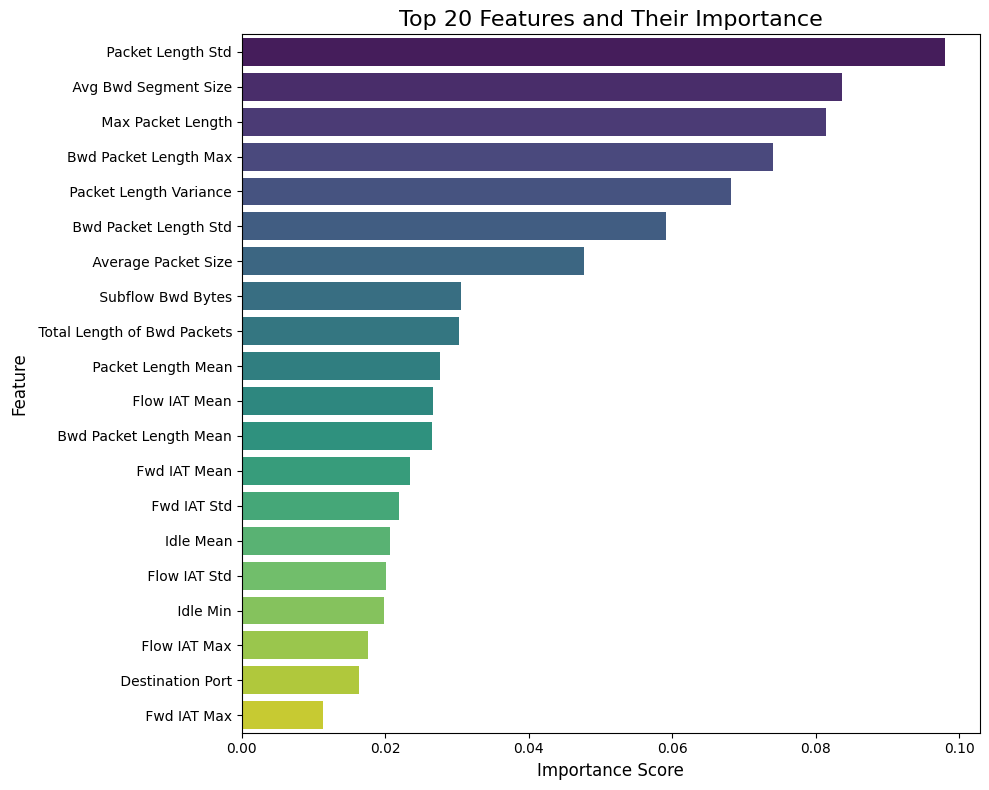

In [14]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Step 1: Train a model to get feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 2: Get feature importance scores
feature_importances = pd.DataFrame({
    'Feature': X.columns,  # Feature names
    'Importance': rf_model.feature_importances_  # Importance scores
})

# Step 3: Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Step 4: Select the top 20 most important features
top_20_features = feature_importances.head(20)['Feature']

# Step 5: Filter the training and test data to include only the top 20 features
X_train_selected = X_train[:, feature_importances.index[:20]]
X_test_selected = X_test[:, feature_importances.index[:20]]

# Display the selected top features
print("Top 20 Features:")
print(top_20_features)

#Visualization
top_20_importance = feature_importances.head(20)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=top_20_importance['Importance'], y=top_20_importance['Feature'], palette="viridis")
plt.title("Top 20 Features and Their Importance", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
# Assuming 'top_20_features' contains the names of the top 20 features
top_20_features = feature_importances.head(20)['Feature']

# Apply the feature selection to the training and test datasets
X_train_selected = X_train[:, [X.columns.get_loc(feature) for feature in top_20_features]]
X_test_selected = X_test[:, [X.columns.get_loc(feature) for feature in top_20_features]]

# Verify the shapes after selecting the top 20 features
print("Training features shape (after selecting top 20 features):", X_train_selected.shape)
print("Test features shape (after selecting top 20 features):", X_test_selected.shape)



# Assuming y_train and y_test are your training and test labels

# Convert numpy arrays to pandas Series for easy value counting
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the class distribution in training and test sets
train_class_distribution = y_train_series.value_counts().sort_index()
test_class_distribution = y_test_series.value_counts().sort_index()

# Display the class distributions
print("Training Set Class Distribution:\n", train_class_distribution)
print("Test Set Class Distribution:\n", test_class_distribution)

Training features shape (after selecting top 20 features): (615252, 20)
Test features shape (after selecting top 20 features): (153814, 20)
Training Set Class Distribution:
 0    458531
1      8229
2    138279
3      4182
4      4308
5         9
6      1176
7        17
8       521
Name: count, dtype: int64
Test Set Class Distribution:
 0    114633
1      2057
2     34570
3      1046
4      1077
5         2
6       294
7         4
8       131
Name: count, dtype: int64


In [16]:
import pandas as pd

pd.set_option('display.width', 1000)
# Assuming 'top_20_features' contains the names of the top 20 features
top_20_features = feature_importances.head(20)['Feature']

# Apply the feature selection to the training and test datasets
X_train_selected = X_train[:, [X.columns.get_loc(feature) for feature in top_20_features]]
X_test_selected = X_test[:, [X.columns.get_loc(feature) for feature in top_20_features]]

# Verify the shapes after selecting the top 20 features
print("Training features shape (after selecting top 20 features):", X_train_selected.shape)
print("Test features shape (after selecting top 20 features):", X_test_selected.shape)

# Assuming y_train and y_test are your training and test labels

# Convert numpy arrays to pandas Series for easy value counting
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count class distribution in training and test sets
train_class_distribution = y_train_series.value_counts().sort_index()
test_class_distribution = y_test_series.value_counts().sort_index()

# Original class distribution (replace with your original y values count)
original_class_distribution = pd.Series(y).value_counts().sort_index()

# Initialize an empty list to store the rows of the table
table_data = []

# Create a dictionary to map class labels to class names
class_mapping = {
    0: 'BENIGN',
    1: 'DoS Hulk',
    2: 'DoS GoldenEye',
    3: 'DoS slowloris',
    4: 'DoS Slowhttptest',
    5: 'Web Attack – Brute Force',
    6: 'Web Attack – XSS',
    7: 'Web Attack – Sql Injection',
    8: 'Heartbleed'
}

# Fill the table data, use unique values in y_train and y_test for mapping
for class_idx in sorted(set(y_train_series.unique()).union(set(y_test_series.unique()))):
    class_name = class_mapping.get(class_idx, "Unknown")
    original_count = original_class_distribution.get(class_idx, 0)
    train_count = train_class_distribution.get(class_idx, 0)
    test_count = test_class_distribution.get(class_idx, 0)
    total_count = train_count + test_count
    difference = original_count - total_count

    table_data.append([class_name, train_count, test_count, total_count, original_count, difference])

# Create a DataFrame to display the table
table_df = pd.DataFrame(table_data, columns=["Class Name", "Count in Training Set", "Count in Test Set",
                                             "Total (Training + Test)", "Original Count", "Difference (Original - Total)"])

# Display the table
print(table_df)


Training features shape (after selecting top 20 features): (615252, 20)
Test features shape (after selecting top 20 features): (153814, 20)
                   Class Name  Count in Training Set  Count in Test Set  Total (Training + Test)  Original Count  Difference (Original - Total)
0                      BENIGN                 458531             114633                   573164          573164                              0
1                    DoS Hulk                   8229               2057                    10286           10286                              0
2               DoS GoldenEye                 138279              34570                   172849          172849                              0
3               DoS slowloris                   4182               1046                     5228            5228                              0
4            DoS Slowhttptest                   4308               1077                     5385            5385                            

<ipython-input-16-cd495619363e>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  original_count = original_class_distribution.get(class_idx, 0)


                   Class Name  Before SMOTE  After SMOTE
0               DoS GoldenEye        138279       458531
1                      BENIGN        458531       458531
2            Web Attack – XSS          1176       458531
3                    DoS Hulk          8229       458531
4               DoS slowloris          4182       458531
5            DoS Slowhttptest          4308       458531
6                  Heartbleed           521       458531
7  Web Attack – Sql Injection            17       458531
8    Web Attack – Brute Force             9       458531
New training features shape (after SMOTE): (4126779, 20)
New training labels shape (after SMOTE): (4126779,)


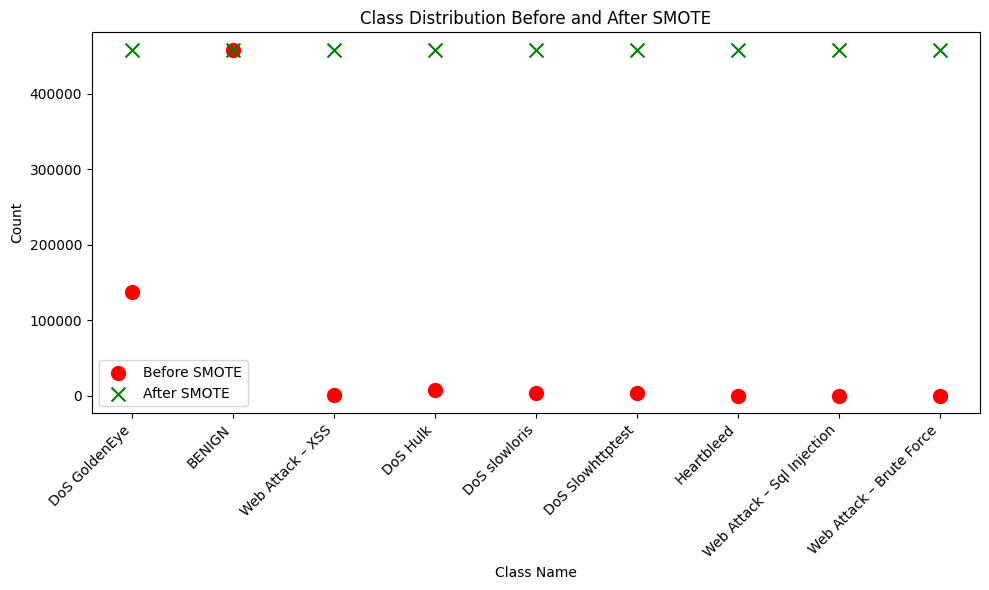

In [17]:
#------------------------ Apply General SMOTE/ No configurations-------------------------------------

from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training set
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Count class distribution before SMOTE
original_class_distribution = Counter(y_train)

# Count class distribution after SMOTE
smote_class_distribution = Counter(y_train_smote)

# Initialize an empty list to store the rows of the table
table_data = []

# Create a dictionary to map class labels to class names
class_mapping = {
    0: 'BENIGN',
    1: 'DoS Hulk',
    2: 'DoS GoldenEye',
    3: 'DoS slowloris',
    4: 'DoS Slowhttptest',
    5: 'Web Attack – Brute Force',
    6: 'Web Attack – XSS',
    7: 'Web Attack – Sql Injection',
    8: 'Heartbleed'
}

# Get the unique classes in the original distribution
unique_classes = list(original_class_distribution.keys())

# Populate the table data with class distribution before and after SMOTE
for class_idx in unique_classes:
    class_name = class_mapping.get(class_idx, "Unknown")  # use the same mapping you have for class names
    before_smote = original_class_distribution.get(class_idx, 0)
    after_smote = smote_class_distribution.get(class_idx, 0)

    table_data.append([class_name, before_smote, after_smote])

# Create a DataFrame to display the table
table_df = pd.DataFrame(table_data, columns=["Class Name", "Before SMOTE", "After SMOTE"])

# Display the table
print(table_df)

# Verify the shape of the new training set
print("New training features shape (after SMOTE):", X_train_smote.shape)
print("New training labels shape (after SMOTE):", y_train_smote.shape)



# Create a scatter plot for the class distribution before and after SMOTE
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for before SMOTE
ax.scatter(table_df['Class Name'], table_df['Before SMOTE'], color='red', label='Before SMOTE', s=100, marker='o')

# Scatter plot for after SMOTE
ax.scatter(table_df['Class Name'], table_df['After SMOTE'], color='green', label='After SMOTE', s=100, marker='x')

# Set labels and title
ax.set_xlabel('Class Name')
ax.set_ylabel('Count')
ax.set_title('Class Distribution Before and After SMOTE')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [18]:
#-----------------------TRAIN the Model with RandomForestClassifier-----------------------------
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [19]:
#Predict the labels for unseen(test) dataset
y_pred=model.predict(X_test_selected) #testDataset is the test feature dataset
print(y_pred)

[2 0 0 ... 0 2 0]


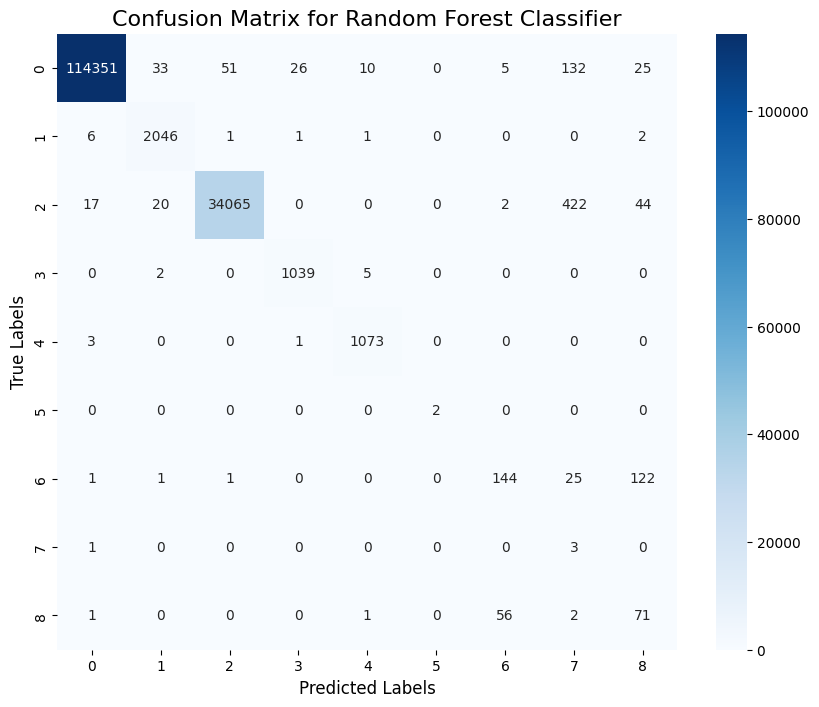

     Class      TP   FP      TN   FN  Misclassification Rate
0  Class 0  114351   29   39152  282                0.002022
1  Class 1    2046   56  151701   11                0.000436
2  Class 2   34065   53  119191  505                0.003628
3  Class 3    1039   28  152740    7                0.000228
4  Class 4    1073   17  152720    4                0.000137
5  Class 5       2    0  153812    0                0.000000
6  Class 6     144   63  153457  150                0.001385
7  Class 7       3  581  153229    1                0.003784
8  Class 8      71  193  153490   60                0.001645
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    114633
           1       0.97      0.99      0.98      2057
           2       1.00      0.99      0.99     34570
           3       0.97      0.99      0.98      1046
           4       0.98      1.00      0.99      1077
           5       1.00      1.00      1.00         2
           

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder if not already imported
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize  # For multi-class AUC

# Assuming you have your original target variable 'y'
label_encoder = LabelEncoder()  # Initialize the LabelEncoder
label_encoder.fit(y_test)  # Fit the LabelEncoder to your target variable

# After training the model and making predictions
y_pred = model.predict(X_test_selected)


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.astype(str), yticklabels=label_encoder.classes_.astype(str))
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Summary of the confusion matrix
TP = []
FP = []
TN = []
FN = []
classes = []

for i in range(cm.shape[0]):
    TP.append(cm[i, i])
    FP.append(cm[:, i].sum() - cm[i, i])
    FN.append(cm[i, :].sum() - cm[i, i])
    TN.append(cm.sum() - (TP[i] + FP[i] + FN[i]))
    classes.append(f'Class {i}')

results_df = pd.DataFrame({'Class': classes, 'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN})

# Calculate Misclassification Rate
results_df['Misclassification Rate'] = (results_df['FP'] + results_df['FN']) / (results_df['TP'] + results_df['FP'] + results_df['TN'] + results_df['FN'])

# Display the results
print(results_df)

# Generate Classification report
reportRF = classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str))
print(reportRF)


#Calculate the Accuracy Score
from sklearn.metrics import accuracy_score
accuracyRF=accuracy_score(y_test,y_pred)
print(f' Accuracy of the model : {accuracyRF : .2f}')


# Precision, Recall, and F1 Score (macro and weighted)
precision_rf = precision_score(y_test, y_pred, average='weighted')  # Change to 'macro' if needed
recall_rf = recall_score(y_test, y_pred, average='weighted')        # Change to 'macro' if needed
f1_rf = f1_score(y_test, y_pred, average='weighted')                # Change to 'macro' if needed

print(f'Weighted Precision: {precision_rf:.2f}')
print(f'Weighted Recall: {recall_rf:.2f}')
print(f'Weighted F1 Score: {f1_rf:.2f}')

# AUC Calculation (for multi-class)
# Convert y_test and y_pred to one-hot encoding
y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
y_proba_rf = model.predict_proba(X_test_selected)  # Predicted probabilities
auc_rf = roc_auc_score(y_test_binarized, y_proba_rf, average='weighted', multi_class='ovr')

print(f'Overall AUC: {auc_rf:.2f}')

In [21]:
# Import XGBoost
from xgboost import XGBClassifier

#-----------------------TRAIN the Model with XGBoost-----------------------------
modelXGB = XGBClassifier(random_state=42)
modelXGB.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
#Predict the labels for unseen(test) dataset
y_predXGB=modelXGB.predict(X_test_selected) #testDataset is the test feature dataset
print(y_predXGB)

[2 0 0 ... 0 2 0]


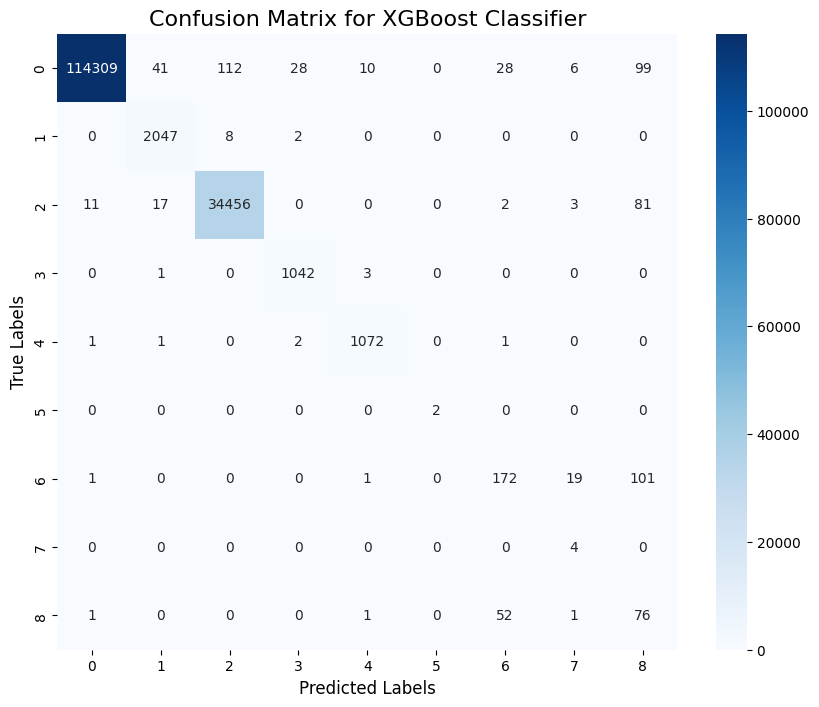

     Class      TP   FP      TN   FN  Misclassification Rate
0  Class 0  114309   14   39167  324                0.002197
1  Class 1    2047   60  151697   10                0.000455
2  Class 2   34456  120  119124  114                0.001521
3  Class 3    1042   32  152736    4                0.000234
4  Class 4    1072   15  152722    5                0.000130
5  Class 5       2    0  153812    0                0.000000
6  Class 6     172   83  153437  122                0.001333
7  Class 7       4   29  153781    0                0.000189
8  Class 8      76  281  153402   55                0.002184
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    114633
           1       0.97      1.00      0.98      2057
           2       1.00      1.00      1.00     34570
           3       0.97      1.00      0.98      1046
           4       0.99      1.00      0.99      1077
           5       1.00      1.00      1.00         2
           

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder if not already imported
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize  # For multi-class AUC

# Assuming you have your original target variable 'y'
label_encoder = LabelEncoder()  # Initialize the LabelEncoder
label_encoder.fit(y_test)  # Fit the LabelEncoder to your target variable

# After training the model and making predictions
y_predXGB = modelXGB.predict(X_test_selected)

# Compute confusion matrix
cmXGB = confusion_matrix(y_test, y_predXGB)

# Display confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmXGB, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.astype(str), yticklabels=label_encoder.classes_.astype(str))
plt.title('Confusion Matrix for XGBoost Classifier', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Summary of the confusion matrix
TP = []
FP = []
TN = []
FN = []
classes = []

for i in range(cmXGB.shape[0]):
    TP.append(cmXGB[i, i])
    FP.append(cmXGB[:, i].sum() - cmXGB[i, i])
    FN.append(cmXGB[i, :].sum() - cmXGB[i, i])
    TN.append(cmXGB.sum() - (TP[i] + FP[i] + FN[i]))
    classes.append(f'Class {i}')

results_dfXGB = pd.DataFrame({'Class': classes, 'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN})

# Calculate Misclassification Rate
results_dfXGB['Misclassification Rate'] = (results_dfXGB['FP'] + results_dfXGB['FN']) / (results_dfXGB['TP'] + results_dfXGB['FP'] + results_dfXGB['TN'] + results_dfXGB['FN'])

# Display the results
print(results_dfXGB)

# Generate Classification report
reportRFXGB = classification_report(y_test, y_predXGB, target_names=label_encoder.classes_.astype(str))
print(reportRFXGB)


#Calculate the Accuracy Score
from sklearn.metrics import accuracy_score
accuracyXGB=accuracy_score(y_test,y_predXGB)
print(f' Accuracy of the model : {accuracyXGB : .2f}')

# Precision, Recall, and F1 Score (macro and weighted)
precision_xgb = precision_score(y_test, y_predXGB, average='weighted')  # Change to 'macro' if needed
recall_xgb = recall_score(y_test, y_predXGB, average='weighted')        # Change to 'macro' if needed
f1_xgb = f1_score(y_test, y_predXGB, average='weighted')                # Change to 'macro' if needed

print(f'Weighted Precision (XGBoost): {precision_xgb:.2f}')
print(f'Weighted Recall (XGBoost): {recall_xgb:.2f}')
print(f'Weighted F1 Score (XGBoost): {f1_xgb:.2f}')

# AUC Calculation (for multi-class)
# Convert y_test to one-hot encoding
y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
y_proba_xgb = modelXGB.predict_proba(X_test_selected)  # Predicted probabilities
auc_xgb = roc_auc_score(y_test_binarized, y_proba_xgb, average='weighted', multi_class='ovr')

print(f'Overall AUC (XGBoost): {auc_xgb:.2f}')

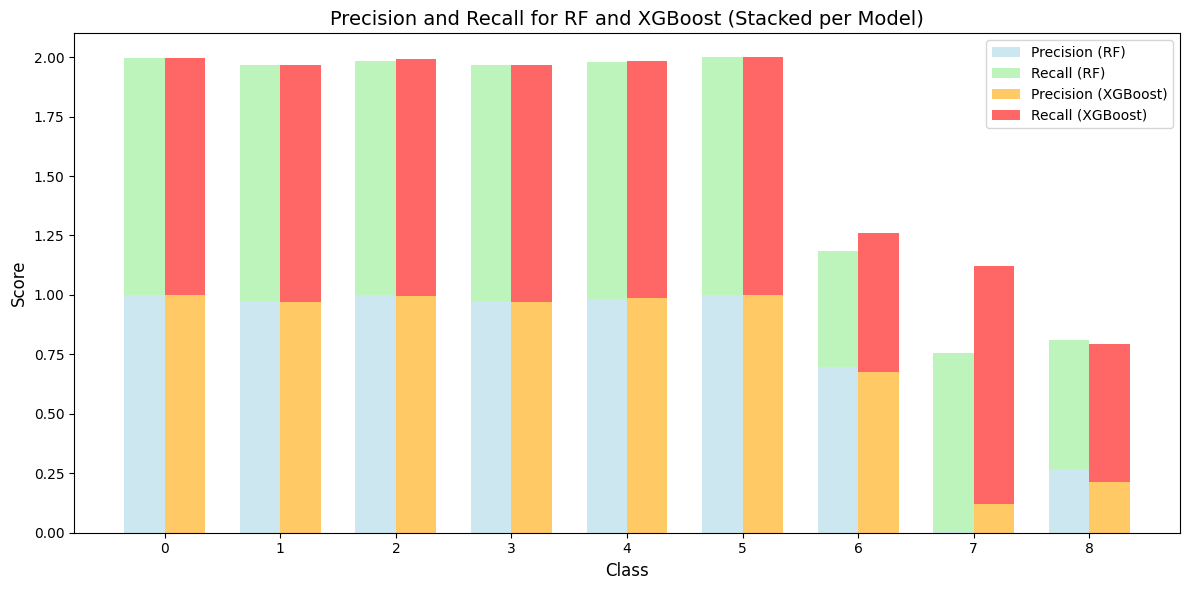

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have the classification reports for both models
# Replace these with your actual classification reports
report_rf = classification_report(y_test, y_pred, output_dict=True)
report_xgb = classification_report(y_test, y_predXGB, output_dict=True)

# Extract precision and recall for each class (0-8) from both reports
precision_rf = [report_rf[str(i)]['precision'] for i in range(9)]
recall_rf = [report_rf[str(i)]['recall'] for i in range(9)]
precision_xgb = [report_xgb[str(i)]['precision'] for i in range(9)]
recall_xgb = [report_xgb[str(i)]['recall'] for i in range(9)]

# Class labels
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Set the positions of the bars
index = np.arange(len(classes))
bar_width = 0.35  # Width of each bar group

# Plot the chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot for RF
ax.bar(index, precision_rf, bar_width, label='Precision (RF)', color='lightblue', alpha=0.6)
ax.bar(index, recall_rf, bar_width, bottom=precision_rf, label='Recall (RF)', color='lightgreen', alpha=0.6)

# Plot for XGBoost (shifted to the right by bar_width)
ax.bar(index + bar_width, precision_xgb, bar_width, label='Precision (XGBoost)', color='orange', alpha=0.6)
ax.bar(index + bar_width, recall_xgb, bar_width, bottom=precision_xgb, label='Recall (XGBoost)', color='red', alpha=0.6)

# Customize the chart
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision and Recall for RF and XGBoost (Stacked per Model)', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()


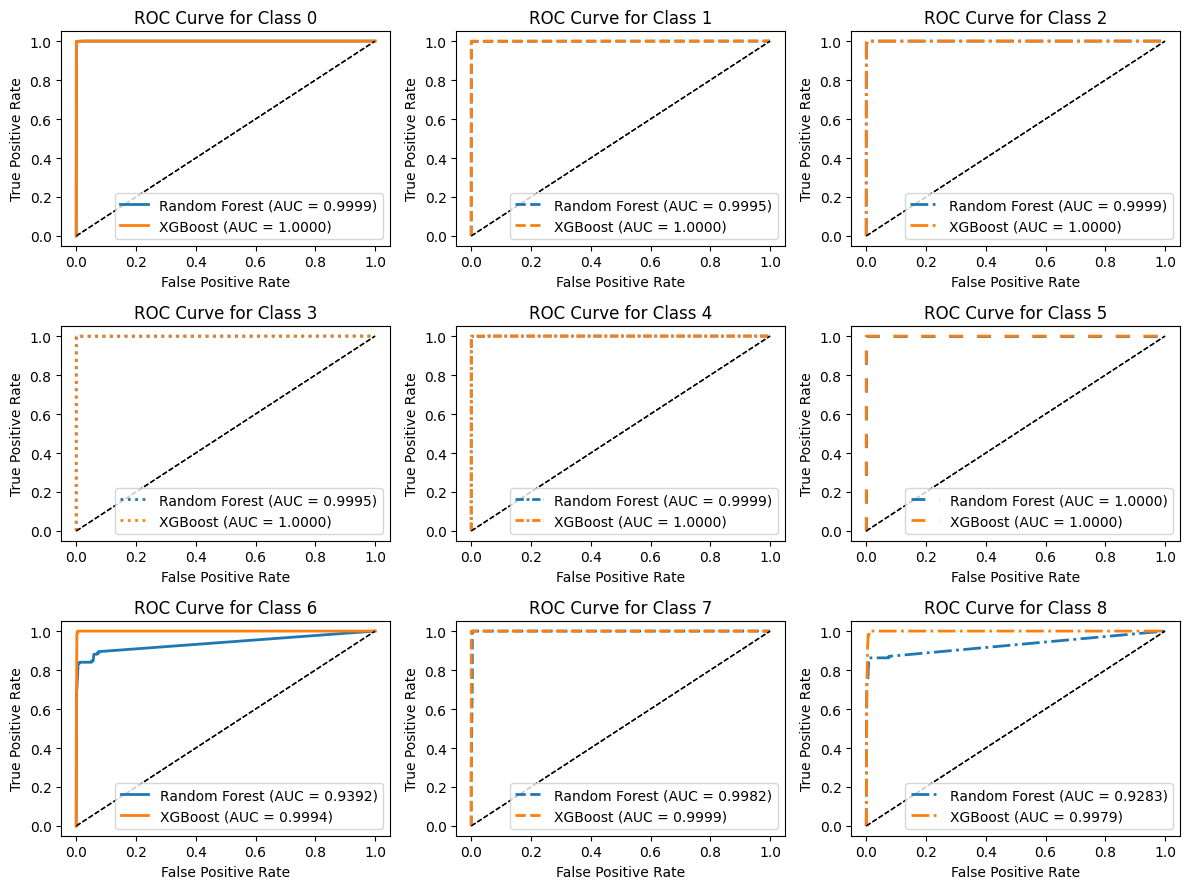

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Assuming your model training is already done like this
# Random Forest model
#rf_model = RandomForestClassifier(random_state=42)
#rf_model.fit(X_train_smote, y_train_smote)

# XGBoost model
#modelXGB = XGBClassifier(random_state=42)
#modelXGB.fit(X_train_smote, y_train_smote)

def plot_multiclass_roc(models, X_test, y_test):
    n_classes = len(np.unique(y_test))  # Number of classes
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5))]  # Line styles for each class

    # Create subplots for each class
    fig, axes = plt.subplots((n_classes + 2) // 3, 3, figsize=(12, 3 * ((n_classes + 2) // 3)))
    axes = axes.ravel()

    # For each class, plot the ROC curve
    for i in range(n_classes):
        for model_name, model in models.items():
            # Get predicted probabilities for class i
            y_proba = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test == i, y_proba[:, i])  # False positive rate, True positive rate
            roc_auc = auc(fpr, tpr)  # Compute AUC score

            # Plot ROC curve
            axes[i].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})',
                         linestyle=line_styles[i % len(line_styles)], linewidth=2)

            # Plot diagonal line (random classifier)
            axes[i].plot([0, 1], [0, 1], 'k--', lw=1)

        # Set title, labels, and legend
        axes[i].set_title(f'ROC Curve for Class {i}')
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Models dictionary
models = {
    "Random Forest": model,
    "XGBoost": modelXGB
}

# Call the function to plot the ROC curves for each class
plot_multiclass_roc(models, X_test_selected, y_test)


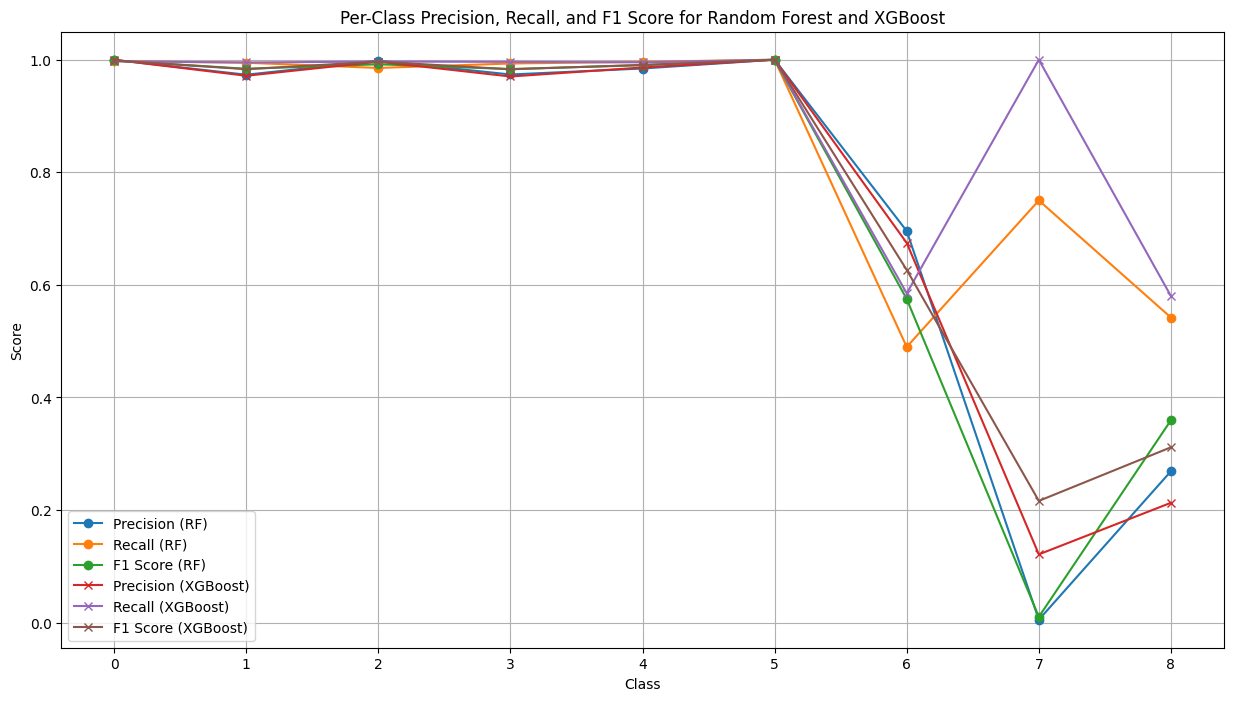


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114633
           1       0.97      0.99      0.98      2057
           2       1.00      0.99      0.99     34570
           3       0.97      0.99      0.98      1046
           4       0.98      1.00      0.99      1077
           5       1.00      1.00      1.00         2
           6       0.70      0.49      0.57       294
           7       0.01      0.75      0.01         4
           8       0.27      0.54      0.36       131

    accuracy                           0.99    153814
   macro avg       0.77      0.86      0.77    153814
weighted avg       1.00      0.99      1.00    153814


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114633
           1       0.97      1.00      0.98      2057
           2       1.00      1.00      1.00     34570
      

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test, y_pred_rf, and y_pred_xgb are already available
# y_test = true labels for your test data
y_pred_rf =y_pred # predicted labels for Random Forest
y_pred_xgb =y_predXGB  # predicted labels for XGBoost

def plot_per_class_metrics(y_true, y_pred_rf, y_pred_xgb):
    # Calculate per-class precision, recall, and F1 score for Random Forest
    precision_rf = precision_score(y_true, y_pred_rf, average=None, zero_division=0)
    recall_rf = recall_score(y_true, y_pred_rf, average=None, zero_division=0)
    f1_rf = f1_score(y_true, y_pred_rf, average=None, zero_division=0)

    # Calculate per-class precision, recall, and F1 score for XGBoost
    precision_xgb = precision_score(y_true, y_pred_xgb, average=None, zero_division=0)
    recall_xgb = recall_score(y_true, y_pred_xgb, average=None, zero_division=0)
    f1_xgb = f1_score(y_true, y_pred_xgb, average=None, zero_division=0)

    # Get the unique classes
    classes = np.unique(y_true)

    # Plot Precision, Recall, and F1 Score for both models
    plt.figure(figsize=(15, 8))

    # Plot Random Forest metrics
    plt.plot(classes, precision_rf, label='Precision (RF)', marker='o')
    plt.plot(classes, recall_rf, label='Recall (RF)', marker='o')
    plt.plot(classes, f1_rf, label='F1 Score (RF)', marker='o')

    # Plot XGBoost metrics
    plt.plot(classes, precision_xgb, label='Precision (XGBoost)', marker='x')
    plt.plot(classes, recall_xgb, label='Recall (XGBoost)', marker='x')
    plt.plot(classes, f1_xgb, label='F1 Score (XGBoost)', marker='x')

    # Labeling the plot
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Per-Class Precision, Recall, and F1 Score for Random Forest and XGBoost')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the metrics
plot_per_class_metrics(y_test, y_pred_rf, y_pred_xgb)

# Print detailed classification reports for both models
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate overall Precision, Recall, and F1 Score for Random Forest
precision_rf = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate overall Precision, Recall, and F1 Score for XGBoost
precision_xgb = precision_score(y_test, y_predXGB, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test, y_predXGB, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test, y_predXGB, average='weighted', zero_division=0)

#Accuracy of Random Forest
accuracy_rf = accuracy_score(y_test, y_pred)
# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_predXGB)

# Calculate AUC for Random Forest (multiclass)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf, multi_class='ovr')
# Calculate AUC for XGBoost (multiclass)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb, multi_class='ovr')

# Print the overall metrics for both models
print(f"Random Forest - Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, F1 Score: {f1_rf:.4f},Accuracy: {accuracy_rf:.4f},AUC: {roc_auc_rf:.4f}")
print(f"XGBoost - Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}, F1 Score: {f1_xgb:.4f}, Accuracy: {accuracy_xgb:.4f},AUC: {roc_auc_xgb:.4f}")





Random Forest - Precision: 0.9976, Recall: 0.9934, F1 Score: 0.9954,Accuracy: 0.9934,AUC: 0.9849
XGBoost - Precision: 0.9971, Recall: 0.9959, F1 Score: 0.9964, Accuracy: 0.9959,AUC: 0.9997
